In [7]:
import sys, os, pickle
sys.path.append('/scratch/oem214/vanilla-rtrl/')
from cluster import *
from continual_learning import *
from core import *
from dynamics import *
from functions import *
from gen_data import *
from learning_algorithms import *
from optimizers import *
from plotting import *
from wrappers import *

In [20]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 5
macro_configs = config_generator(sigma=[0.01, 0.03, 0.07],
                                 decay=[1, 0.7, 0.3])
micro_configs = tuple(product(macro_configs, list(range(n_seeds))))

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = True
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [9]:
task = Flip_Flop_Task(3, 0.05, input_magnitudes=None)
N_train = 200000
N_test = 2000
checkpoint_interval = None

data = task.gen_data(N_train, N_test)

n_in = task.n_in
n_hidden = 32
n_out = task.n_out
W_in  = np.random.normal(0, np.sqrt(1/(n_in)), (n_hidden, n_in))
W_rec = np.random.normal(0, np.sqrt(1/n_hidden), (n_hidden, n_hidden))
W_out = np.random.normal(0, np.sqrt(1/(n_hidden)), (n_out, n_hidden))

b_rec = np.zeros(n_hidden)
b_out = np.zeros(n_out)

alpha = 1
sigma = params['sigma']

rnn = RNN(W_in, W_rec, W_out, b_rec, b_out,
          activation=tanh,
          alpha=alpha,
          output=identity,
          loss=mean_squared_error)

learn_alg = REINFORCE(rnn, sigma=sigma, decay=params['decay'])
optimizer = Stochastic_Gradient_Descent(lr=0.001)

monitors = []

sim = Simulation(rnn)
sim.run(data, learn_alg=learn_alg, optimizer=optimizer,
        sigma=sigma,
        monitors=monitors,
        verbose=True,
        report_accuracy=False,
        report_loss=True,
        checkpoint_interval=checkpoint_interval)

Progress: 10.0% complete 
Time Elapsed: 4.7s 
Test loss: 0.6217204619275323 

Progress: 20.0% complete 
Time Elapsed: 9.6s 
Test loss: 0.506072600433436 

Progress: 30.0% complete 
Time Elapsed: 14.4s 
Test loss: 0.6166458269962242 

Progress: 40.0% complete 
Time Elapsed: 19.4s 
Test loss: 0.6083310586474602 

Progress: 50.0% complete 
Time Elapsed: 24.1s 
Test loss: 0.6215171986465243 

Progress: 60.0% complete 
Time Elapsed: 28.9s 
Test loss: 0.7096322058865426 

Progress: 70.0% complete 
Time Elapsed: 33.7s 
Test loss: 0.6851894596800939 

Progress: 80.0% complete 
Time Elapsed: 38.5s 
Test loss: 0.6001343376882046 

Progress: 90.0% complete 
Time Elapsed: 43.3s 
Test loss: 0.6053365652918897 



In [ ]:
test_sim = Simulation(rnn)
mode = 'test'
if 'task_marker' in data['train'].keys():
    mode += '_{}'.format(data['train']['task_marker'][-1])
test_sim.run(data, mode=mode, monitors=['rnn.loss_'], verbose=False)
processed_data = np.mean(test_sim.mons['rnn.loss_'])

In [ ]:
### --- SAVE RESULTS -- ###
result = {'sim': sim, 'i_seed': i_seed, 'task': task,
          'config': params, 'i_config': i_config, 'i_job': i_job}
try:
    result['processed_data'] = processed_data
except NameError:
    pass
    
try:
    save_dir = os.environ['SAVEDIR']
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, 'result_{}'.format(i_job))

    with open(save_path, 'wb') as f:
        pickle.dump(result, f)
except KeyError:
    pass

In [22]:
###Truncate file above
file_name = 'reinforce_fail_array'
job_name = 'rein_sigma_decay_array_2'
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')
get_ipython().system('jupyter nbconvert --to script --no-prompt {}.ipynb'.format(file_name))
get_ipython().system('awk "/###Truncate/ {{exit}} {{print}}" {}.py'.format(file_name))
get_ipython().system('sed -i "/###Truncate/Q" {}.py'.format(file_name))
get_ipython().system('mv {}.py ../cluster_main_scripts/{}.py'.format(file_name, job_name))

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook reinforce_fail_array.ipynb to script
[NbConvertApp] Writing 5702 bytes to reinforce_fail_array.py
awk: 1: unexpected character '.'


In [23]:
###Submit job to cluster
n_jobs = len(micro_configs)
write_job_file(job_name, py_file_name='{}.py'.format(job_name))
job_id_1 = submit_job('../job_scripts/{}.s'.format(job_name), n_jobs)

rm: cannot remove '/scratch/oem214/learning-dynamics/results/rein_sigma_decay_array_2/result_*': No such file or directory
sending incremental file list
vanilla-rtrl/
vanilla-rtrl/.DS_Store
vanilla-rtrl/.gitignore
vanilla-rtrl/README.md
vanilla-rtrl/__init__.py
vanilla-rtrl/analyze_main.py
vanilla-rtrl/compare_main.py
vanilla-rtrl/cross_compare_main.py
vanilla-rtrl/jupyter_notebook.py
vanilla-rtrl/test.py
vanilla-rtrl/test_2.py
vanilla-rtrl/.idea/
vanilla-rtrl/.idea/misc.xml
vanilla-rtrl/.idea/modules.xml
vanilla-rtrl/.idea/vanilla-rtrl.iml
vanilla-rtrl/.idea/vcs.xml
vanilla-rtrl/.idea/workspace.xml
vanilla-rtrl/.idea/codeStyles/
vanilla-rtrl/.idea/codeStyles/codeStyleConfig.xml
vanilla-rtrl/.ipynb_checkpoints/
vanilla-rtrl/.ipynb_checkpoints/main-checkpoint.ipynb
vanilla-rtrl/.ipynb_checkpoints/test_interface-checkpoint.ipynb
vanilla-rtrl/__pycache__/
vanilla-rtrl/__pycache__/analysis.cpython-36.pyc
vanilla-rtrl/__pycache__/analysis_funcs.cpython-36.pyc
vanilla-rtrl/__pycache__/analys

vanilla-rtrl/gen_data/__pycache__/Sine_Wave.cpython-38.pyc
vanilla-rtrl/gen_data/__pycache__/Task.cpython-37.pyc
vanilla-rtrl/gen_data/__pycache__/Task.cpython-38.pyc
vanilla-rtrl/gen_data/__pycache__/__init__.cpython-37.pyc
vanilla-rtrl/gen_data/__pycache__/__init__.cpython-38.pyc
vanilla-rtrl/gen_data/__pycache__/gen_data_utils.cpython-37.pyc
vanilla-rtrl/gen_data/__pycache__/gen_data_utils.cpython-38.pyc
vanilla-rtrl/learning_algorithms/
vanilla-rtrl/learning_algorithms/DNI.py
vanilla-rtrl/learning_algorithms/Efficient_BPTT.py
vanilla-rtrl/learning_algorithms/Future_BPTT.py
vanilla-rtrl/learning_algorithms/KF_RTRL.py
vanilla-rtrl/learning_algorithms/KeRNL.py
vanilla-rtrl/learning_algorithms/Learning_Algorithm.py
vanilla-rtrl/learning_algorithms/List_of_Gradients.py
vanilla-rtrl/learning_algorithms/Miconi_REINFORCE.py
vanilla-rtrl/learning_algorithms/Only_Output_Weights.py
vanilla-rtrl/learning_algorithms/REINFORCE.py
vanilla-rtrl/learning_algorithms/RFLO.py
vanilla-rtrl/learning_alg

In [24]:
job_name = 'rein_sigma_decay_array_2'

In [31]:
###Get job status
get_ipython().system('squeue -u oem214')

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          13681021        cm  jupyter   oem214  R    3:46:29      1 cm037


In [28]:
configs_array, results_array, key_order, sim_dict = unpack_processed_data('../job_scripts/{}.s'.format(job_name))

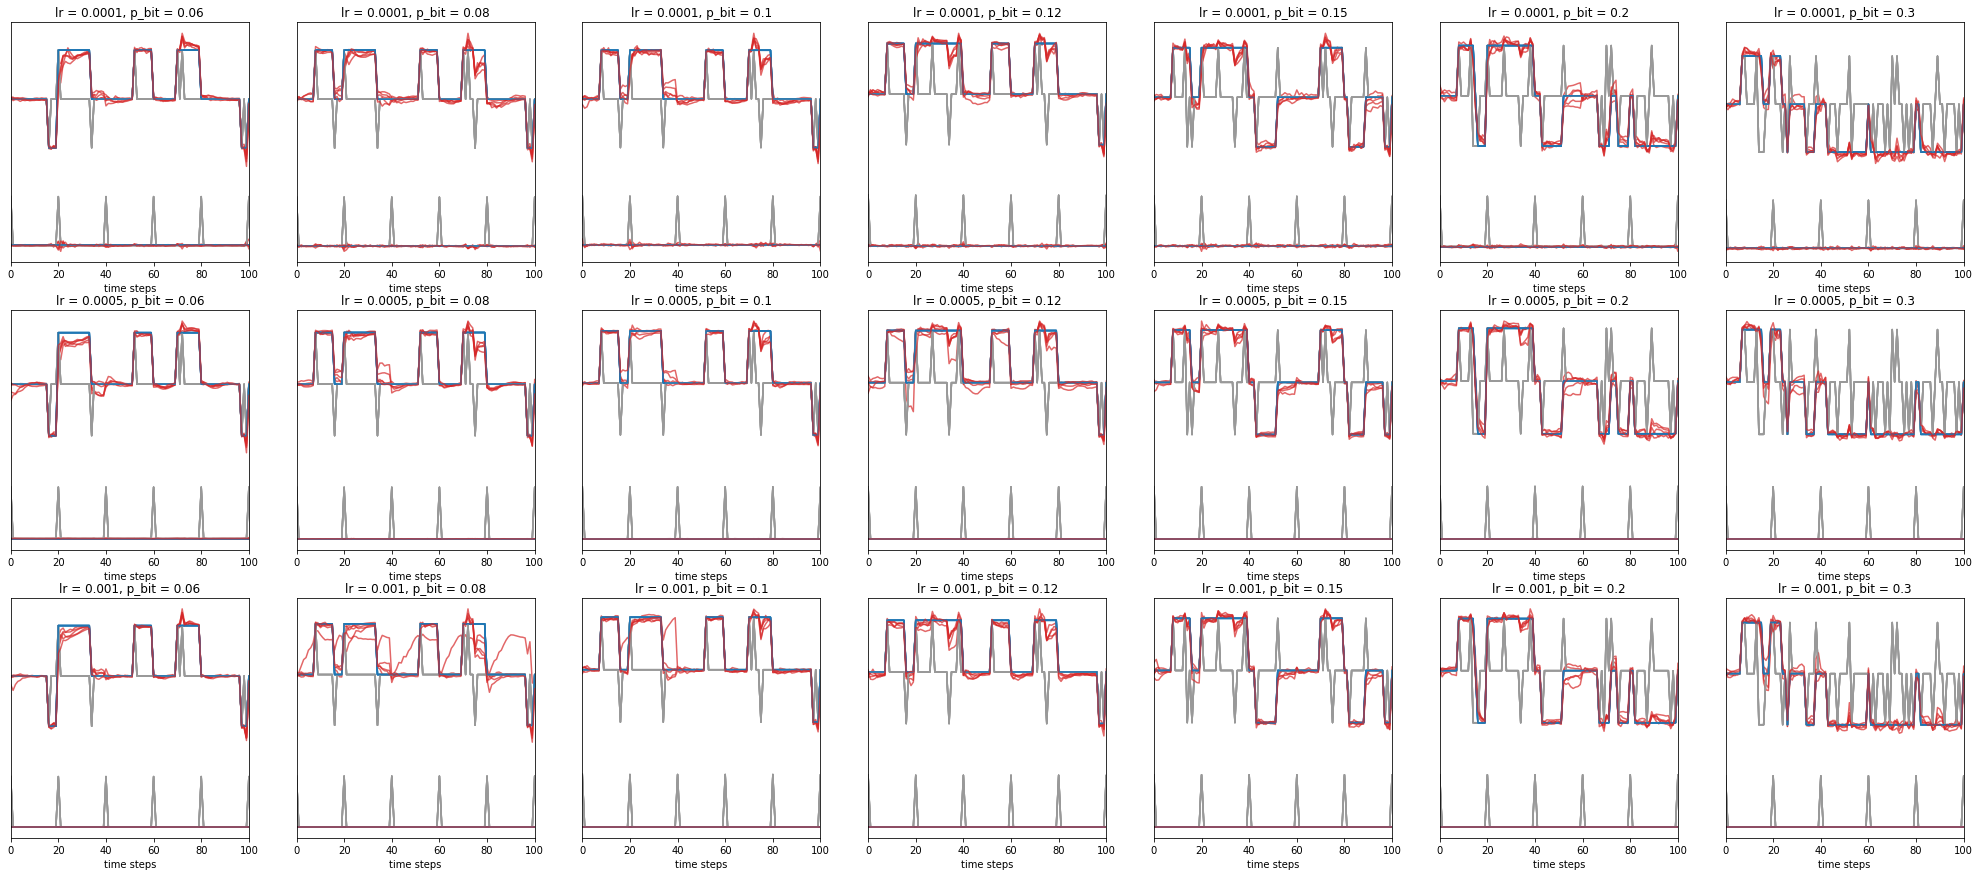

In [10]:
#task = Flip_Flop_Task(3, 0.05, input_magnitudes=None)
task_dict = {}
for key in sim_dict.keys():
    
    p_bit = float(key.split('_')[1])
#    p_reset = float(key.split('_')[1])
    task_dict[key] = Discrete_Integration_Task(p_bit=p_bit, p_reset=0.05, reset_mode='regular')
    
#task = Discrete_Integration_Task(p_bit=0.1, p_reset=0.02)
#data = task.gen_data(0, 200)
#data = tasks[-1].gen_data(0, 200)
fig = plot_1d_or_2d_array_of_config_examples(configs_array, results_array,
                                             key_order, sim_dict, data=None,
                                             task_dict=task_dict, N_task_data=200,
                                             xlim=100, trace_spacing=3)

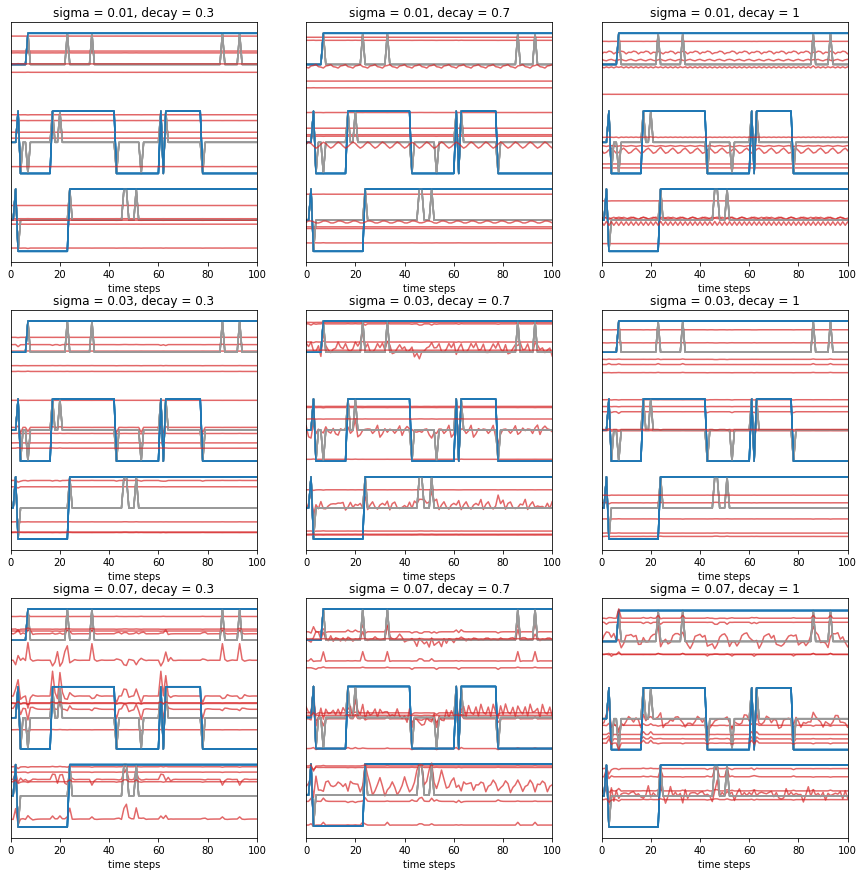

In [32]:
fig = plot_1d_or_2d_array_of_config_examples(configs_array, results_array,
                                             key_order, sim_dict, data=data,
                                             task_dict=None, N_task_data=200,
                                             xlim=100, trace_spacing=2.5)
figs_path = 'figs/talk_1-12/'
fig_name = 'sigma_decay_array_2'
#fig.savefig(os.path.join(figs_path, '{}.pdf'.format(fig_name)), format='pdf')

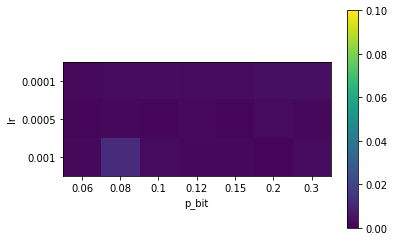

In [33]:
fig = plot_2d_array_of_config_results(configs_array, results_array, key_order,
                                      log_scale=False, tick_rounding=5, vmin=0, vmax=0.1)

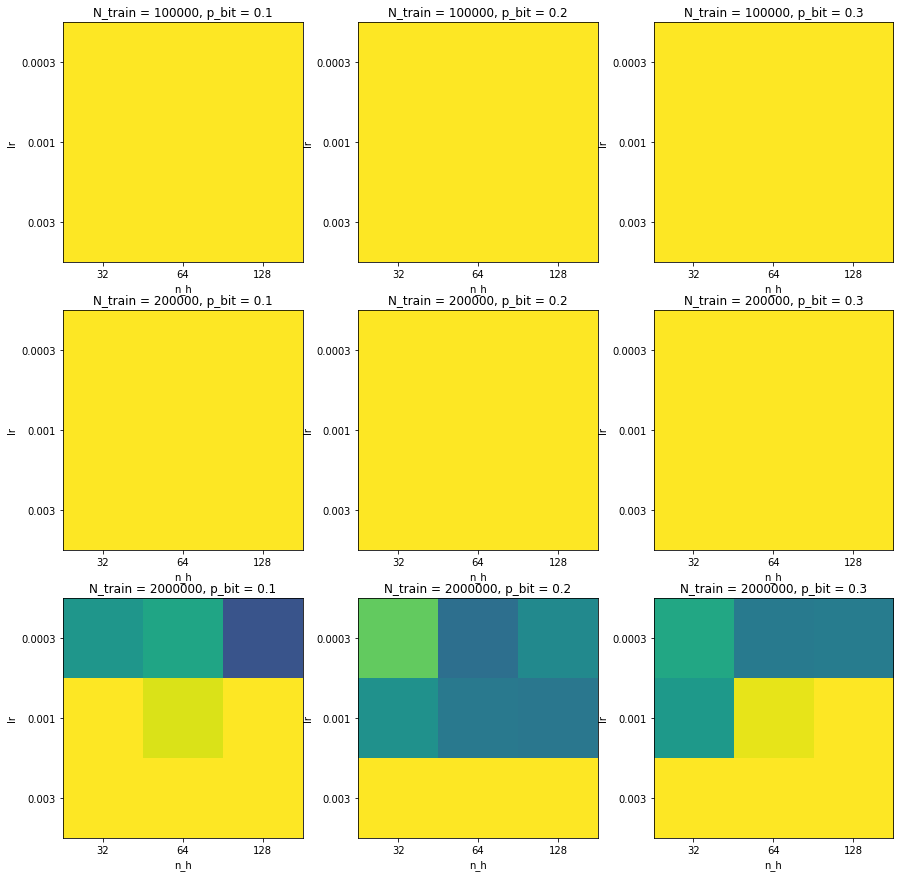

In [4]:
fig = plot_3d_or_4d_array_of_config_results(configs_array, results_array, key_order, tick_rounding=5,
                                            vmin=0, vmax=0.005)

In [58]:
figs_path = 'figs/discrete_integration/'
fig_name = 'array_7_loss'
fig.savefig(os.path.join(figs_path, '{}.pdf'.format(fig_name)), format='pdf')

In [ ]:
np.where(results_array.mean(-1) < 0.005)

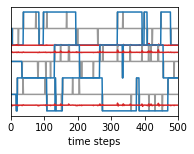

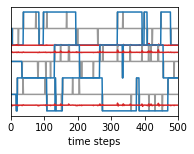

In [3]:
#sim = sim_dict['0.001_0.9_32_3']
plot_output_from_checkpoint(sim.checkpoints[max(sim.checkpoints.keys())], data)

In [ ]:
task = Flip_Flop_Task(3, 0.05, input_magnitudes=None)
N_train = 200000
N_test = 5000
checkpoint_interval = None
sigma = 0

data = task.gen_data(N_train, N_test)

In [ ]:
configs_array